In [27]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

# <center>Computational Mathematics Report</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group #35</center>

## Track

(M1) is a SVC with *hinge* and *squared hinge* losses; *linear*, *polynomial* and *gaussian* kernels.

(A1.1) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVC in its *primal* formulation with the non-differentiable *hinge* loss and a standard gradient descent algorithm for the *squared hinge* loss.

(A1.2) is the *Sequential Minimal Optimization* (SMO) algorithm [[2]](#ref-2) (see [[3]](#ref-3) for improvements), an ad-hoc *active set* method for training a SVM in its *Wolfe dual* formulation.

(A1.3) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVC in its *Lagrangian dual* formulation.

(M2) is a SVR with *epsilon-insensitive* and *squared epsilon-insensitive* losses; *linear*, *polynomial* and *gaussian* kernels.

(A2.1) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVR in its *primal* formulation with the non-differentiable *epsilon-insensitive* loss and a standard gradient descent algorithm for the *squared epsilon-insensitive* loss.

(A2.2) is the *Sequential Minimal Optimization* (SMO) algorithm [[4]](#ref-4) (see [[5]](#ref-5) for improvements), an ad-hoc *active set method* for training a SVM in its *Wolfe dual* formulation.

(A2.3) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVR in its *Lagrangian dual* formulation.

## Abstract

**OptiML**, for what about the ***opti*** module, is a collection of the most successful optimization algorithms, both *constrained* and *unconstrained*, used in the machine learning context. 

To investigate its behavior we will refer to a learning model known as *Support Vector Machine* for which its *primal*, *dual* and *bi-dual* mathematically equivalents formulations give rise to a *constrained* or *unconstrained* optimization problem.

This work was motivated also by the desire to highlight the *strengths* and *weaknesses* of these formulations in terms of *numerical precision*, *time*, *rate of convergence*, *accuracy*, *number of support vectors*, etc. also by comparing them with *sklearn* SVM implementation and *cvxopt* QP solver.

## Support Vector Machines

A *support vector machine* constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for *classification* or *regression*. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.

In [91]:
results = dict()

results['formulation'] = []
results['loss'] = []
results['kernel'] = []
results['implementation'] = []
results['time'] = []
results['score'] = []
results['support_vectors'] = []

### Support Vector Classifier

#### Linearly Separable Binary Classification

Given $n$ training points, where each input $x_i$ has $m$ attributes (i.e., is of dimensionality $m$) and is in one of two classes $y_{i}=\pm1$, i.e our training data is of the form:

$$
\{x_i,y_{i}\} \ \text{where} \ i=1, \dots, n, x_i\in\Re^{m}, y_{i}\in\{+1,-1\}
$$

we assume the data is linearly separable, meaning that we can draw a line on a graph of $x_{1}$ vs $x_{2}$ separating the two classes when $m=2$ and a hyperplane on graphs of $x_{1}, x_{2}$, $\dots$, $x_{m}$ for when $m>2$.

This hyperplane can be described by $\langle w, x \rangle +b=0$ where $w$ is normal to the hyperplane and $\displaystyle \frac{b}{\Vert w\Vert}$ is the perpendicular distance from the hyperplane to the origin.

Support vectors are the examples closest to the separating hyperplane and the aim of support vector machines is to orientate this hyperplane in such a way as to be as far as possible from the closest members of both classes.

<img src="./img/svc_hard.png" width=600/>

Referring to this figure, implementing a SVM boils down to selecting the variables $w$ and $b$ so that our training data can be described by:

$$
\begin{equation}
    \langle w, x_i \rangle +b\geq+1 \ \text{for} \ y_{i}=+1 \tag{1.1}
\end{equation}
$$
$$
\begin{equation}
    \langle w, x_i \rangle +b\leq-1 \ \text{for} \ y_{i}=-1 \tag{1.2}
\end{equation}
$$ 

These equations can be combined into:

$$
\begin{equation}
    y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i} \tag{1.3}
\end{equation}
$$ 

If we now just consider the points that lie closest to the separating hyperplane, i.e., the Support Vectors (shown in circles in the diagram), then the two planes $H_{1}$ and $H_{2}$ that these points lie on can be described by:

$$
\begin{equation}
    \langle w, x_i \rangle +b=+1 \ \text{for} \ H_{1} \tag{1.4}
\end{equation}
$$ 
$$
\begin{equation}
    \langle w, x_i \rangle +b=-1 \ \text{for} \ H_{2} \tag{1.5}
\end{equation}
$$ 

Referring to the previous figure, we define $d_{1}$ as being the distance from $H_{1}$ to the hyperplane and $d_{2}$ from $H_{2}$ to it. The hyperplane's equidistance from $H_{1}$ and $H_{2}$ means that $d_{1}=d_{2}-$ a quantity known as the SVM's margin. In order to orientate the hyperplane to be as far from the Support Vectors as possible, we need to maximize this margin.

Simple vector geometry shows that the margin is equal to $\displaystyle \frac{1}{\Vert w\Vert}$ and maximizing it subject to the constraint in (1.3) is equivalent to finding:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b} \quad & \Vert w \Vert \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i}
    \end{aligned} \tag{1.6}
\end{equation}
$$

Minimizing $\Vert w\Vert$ is equivalent to minimizing $\displaystyle \frac{1}{2}\Vert w\Vert^{2}$, so we need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b} \quad & \frac{1}{2} \Vert w \Vert^2 \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i}
    \end{aligned} \tag{1.7}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 +
        \begin{cases}
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b)) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b))^2 & \text{if using L2 loss}
          \end{cases} \tag{1.8}
\end{equation}
$$

where we make use of the Hinge (L1 loss) and squared Hinge (L2 loss) loss respectively.

In [92]:
import numpy as np

from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.5111 - val_acc:  0.5333
  50	  50	 4.3704e-02 - val_loss:  6.8604e-02 - acc:  1.0000 - val_acc:  1.0000
 100	 100	 2.8564e-02 - val_loss:  4.8817e-02 - acc:  1.0000 - val_acc:  1.0000
 150	 150	 2.4598e-02 - val_loss:  4.7388e-02 - acc:  1.0000 - val_acc:  1.0000
 200	 200	 2.2485e-02 - val_loss:  5.1927e-02 - acc:  1.0000 - val_acc:  1.0000
 250	 250	 2.0913e-02 - val_loss:  5.5958e-02 - acc:  1.0000 - val_acc:  1.0000
 300	 300	 1.9921e-02 - val_loss:  5.9410e-02 - acc:  1.0000 - val_acc:  1.0000
 350	 350	 1.9215e-02 - val_loss:  6.2351e-02 - acc:  1.0000 - val_acc:  1.0000
 400	 400	 1.8978e-02 - val_loss:  6.4271e-02 - acc:  1.0000 - val_acc:  1.0000
 450	 450	 1.8745e-02 - val_loss:  6.6235e-02 - acc:  1.0000 - val_acc:  1.0000
 500	 500	 1.8513e-02 - val_loss:  6.8132e-02 - acc:  1.0000 - val_acc:  1.0000
 550	 550	 1.8455e-02 - val_loss:  6.9020e-02 - acc:  1.0000 - val_acc:  1.0000
 600	 600	 1.8420e-02 

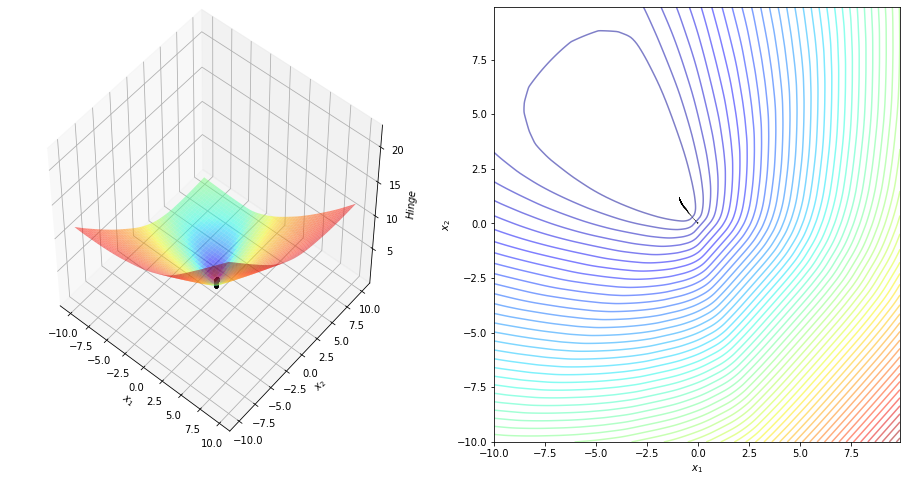

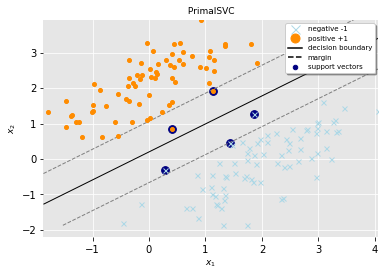

svc accuracy score is 1.0
svc found 5 support vectors from 150 examples
svc w is [-0.9123529   1.15545922]
svc b is -0.23182183822314936

1.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


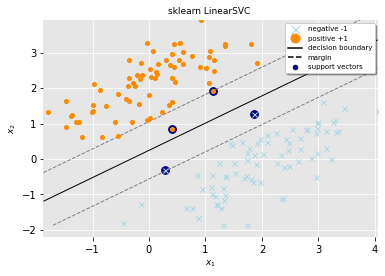

sklearn svc accuracy score is 1.0
sklearn svc found 4 support vectors from 150 examples
sklearn svc w is [[-0.94986748  1.2366862 ]]
sklearn svc b is [-0.3029034]


In [93]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [94]:
results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.5037 - val_acc:  0.4667
  50	  50	 1.7265e-02 - val_loss:  6.7664e-02 - acc:  1.0000 - val_acc:  1.0000
 100	 100	 1.7665e-02 - val_loss:  8.6334e-02 - acc:  1.0000 - val_acc:  1.0000
 150	 150	 1.8894e-02 - val_loss:  9.8435e-02 - acc:  1.0000 - val_acc:  1.0000
 200	 200	 1.9388e-02 - val_loss:  1.0614e-01 - acc:  1.0000 - val_acc:  1.0000
 250	 250	 1.9573e-02 - val_loss:  1.1214e-01 - acc:  1.0000 - val_acc:  1.0000
 300	 300	 1.9880e-02 - val_loss:  1.1601e-01 - acc:  1.0000 - val_acc:  1.0000
 350	 350	 2.0084e-02 - val_loss:  1.1867e-01 - acc:  1.0000 - val_acc:  1.0000
 400	 400	 2.0350e-02 - val_loss:  1.2119e-01 - acc:  1.0000 - val_acc:  1.0000
 450	 450	 2.0514e-02 - val_loss:  1.2299e-01 - acc:  1.0000 - val_acc:  1.0000
 500	 500	 2.0367e-02 - val_loss:  1.2251e-01 - acc:  1.0000 - val_acc:  1.0000
 550	 550	 2.0273e-02 - val_loss:  1.2216e-01 - acc:  1.0000 - val_acc:  1.0000
 600	 600	 2.0239e-02 

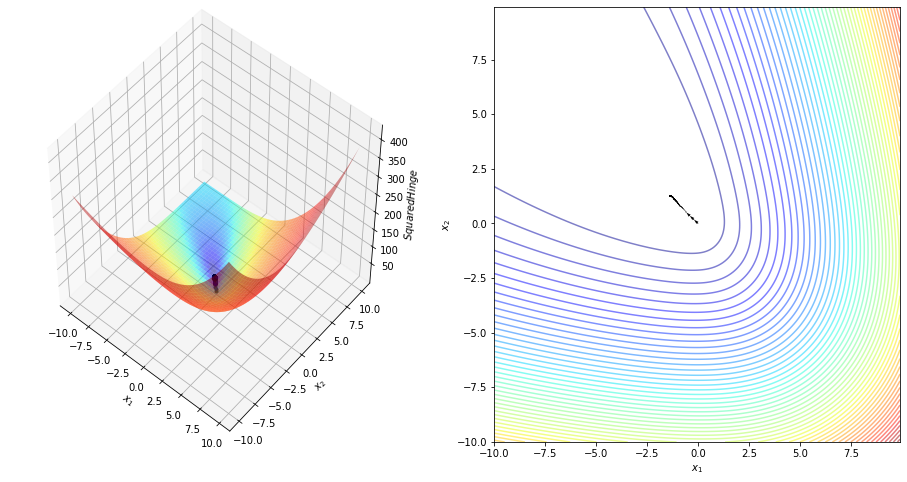

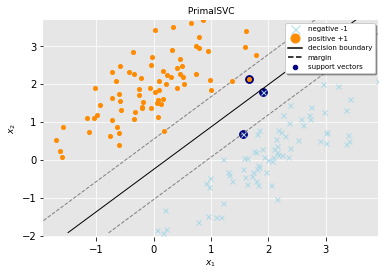

svc accuracy score is 1.0
svc found 3 support vectors from 150 examples
svc w is [-1.40338931  1.25532051]
svc b is 0.3080804026302189

1.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


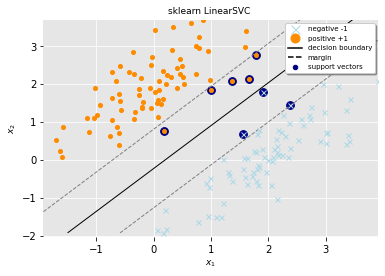

sklearn svc accuracy score is 1.0
sklearn svc found 8 support vectors from 150 examples
sklearn svc w is [[-1.09170004  0.96493866]]
sklearn svc b is [0.21534866]


In [95]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='squared_hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [96]:
results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

In order to cater for the constraints in this minimization, we need to allocate them Lagrange multipliers $\alpha$, where $\alpha_{i}\geq 0 \ \forall_{i}$:

$$
\begin{align*}
    \mathcal{W}(w,b,\alpha) \displaystyle &= \frac{1}{2}\Vert w\Vert^{2}-\alpha[y_{i}(\langle w, x_i \rangle +b)-1 \ \forall_{i}] \tag{1.9} \\
    &= \displaystyle \frac{1}{2}\Vert w\Vert^{2}-\sum_{i=1}^{n}\alpha_{i}[y_{i}(\langle w, x_i \rangle +b)-1] \tag{1.10} \\
    &= \displaystyle \frac{1}{2}\Vert w\Vert^{2}-\sum_{i=1}^{n}\alpha_{i}y_{i}(\langle w, x_i \rangle +b)+\sum_{i=1}^{n}\alpha_{i} \tag{1.11}
\end{align*}
$$

We wish to find the $w$ and $b$ which minimizes, and the $\alpha$ which maximizes $\mathcal{W}$ (whilst keeping $\alpha_{i}\geq 0 \ \forall_{i}$). We can do this by differentiating $\mathcal{W}$ with respect to $w$ and $b$ and setting the derivatives to zero:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}\alpha_{i}y_i x_i \tag{1.12}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=0\Rightarrow\sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.13}
\end{equation}
$$

Substituting (1.12) and (1.13) into (1.11) gives a new formulation which, being dependent on $\alpha$, we need to maximize:

$$
\begin{align*}
    \mathcal{W}(\alpha) \displaystyle &= \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\sum_{i,j}\alpha_{i}\alpha_{j}y_{i}y_{j} \langle x_i, x_j \rangle \ \text{subject to} \ \alpha_{i}\geq 0 \ \forall_{i}, \displaystyle \sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.14} \\
    &= \displaystyle \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\sum_{i,j}\alpha_{i}Q_{ij}\alpha_{j} \ \text{where} \ Q_{ij} = y_{i}y_{j} \langle x_{i}, x_{j} \rangle \tag{1.15} \\
    &= \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\alpha^{T}Q\alpha \ \text{subject to} \ \alpha_{i}\geq 0 \ \forall_{i}, \displaystyle \sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.16}
\end{align*}
$$

This new formulation $\mathcal{W}$ is referred to as the *Wolfe dual* form of the *primary* formulation. It is worth noting that the dual form requires only the dot product of each input vector $x_{i}$ to be calculated, this is important for the *kernel trick* discussed later.

Having moved from minimizing $\mathcal{W}(w,b,\alpha)$ to maximizing $\mathcal{W}(\alpha)$, we need to minimize:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & \alpha_{i}\geq 0 \ \forall_{i} \\ & y^T\alpha=0
    \end{aligned} \tag{1.17}
\end{equation}
$$

where $q$ is a vector of all ones.

This is a convex quadratic optimization problem, and we run a QP solver which will return $\alpha$ and from (1.12) will give us $w$. What remains is to calculate $b.$

Any data point satisfying (1.13) which is a Support Vector $x_{s}$ will have the form:

$$y_{s}(\langle w, x_{s} \rangle +b)=1$$

Substituting in (1.12):

$$y_{s}(\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle +b)=1$$

Where $S$ denotes the set of indices of the support vectors. $S$ is determined by finding the indices $i$ where $\alpha_{i}>0$. Multiplying through by $y_{s}$ and then using $y_{s}^{2}=1$ from (1.1) and (1.2):

$$y_{s}^{2}(\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle +b)=y_{s}$$
$$b=y_{s}-\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle$$

Instead of using an arbitrary support vector $x_{s}$, it is better to take an average over all of the support vectors in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_{s}}\sum_{s\in S}(y_{s}-\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle) \tag{1.18}
\end{equation}
$$

We now have the variables $w$ and $b$ that define our separating hyperplane's optimal orientation and hence our support vector machine. Each new point $x'$ is classified by evaluating:

$$
\begin{equation}
    y'=\displaystyle \operatorname{sgn}(\sum_{i=1}^{n}\alpha_i y_i\langle x_{i}, x' \rangle+b) \tag{1.19}
\end{equation}
$$

In [97]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.2418e+00
   1	-2.3042e+00
   2	-2.4926e+00
   3	-2.5034e+00
   4	-2.5034e+00

27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


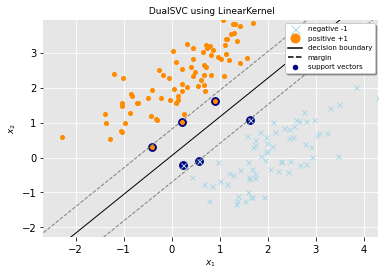

svc accuracy score is 1.0
svc found 6 support vectors from 150 examples
svc w is [-1.46101567  1.312853  ]
svc b is -0.0693281839437085

     pcost       dcost       gap    pres   dres
 0: -1.2277e+01 -2.5840e+02  1e+03  2e+00  5e-15
 1: -6.3296e+00 -1.2511e+02  2e+02  2e-01  3e-15
 2: -1.3009e+00 -1.6605e+01  2e+01  2e-02  3e-15
 3: -1.5381e+00 -4.8326e+00  4e+00  3e-03  1e-15
 4: -1.9627e+00 -3.7924e+00  2e+00  1e-03  9e-16
 5: -2.0878e+00 -3.3284e+00  1e+00  4e-04  8e-16
 6: -2.3306e+00 -2.8660e+00  6e-01  1e-04  9e-16
 7: -2.4402e+00 -2.6777e+00  2e-01  1e-05  9e-16
 8: -2.5327e+00 -2.5693e+00  4e-02  2e-06  1e-15
 9: -2.5479e+00 -2.5508e+00  3e-03  2e-16  1e-15
10: -2.5493e+00 -2.5493e+00  4e-05  2e-16  1e-15
11: -2.5493e+00 -2.5493e+00  4e-07  2e-16  1e-15
Optimal solution found.

111 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


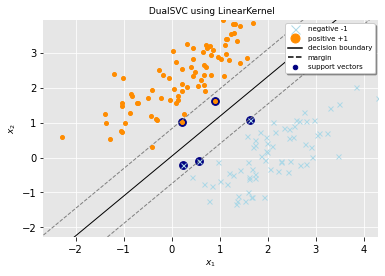

cvxopt svc accuracy score is 1.0
cvxopt svc found 5 support vectors from 150 examples
cvxopt svc w is [-1.44921166  1.26733927]
cvxopt svc b is -0.04731651527821175

1.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


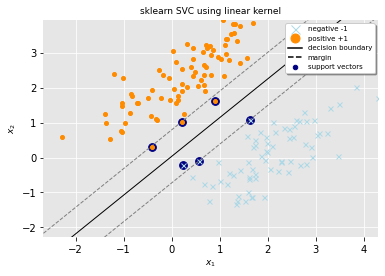

sklearn svc accuracy score is 1.0
sklearn svc found 6 support vectors from 150 examples
sklearn svc w is [[-1.46101567  1.31285298]]
sklearn svc b is [-0.04420434]


In [98]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, optimizer=SMOClassifier, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=linear, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
cvxopt_accuracy = svc.score(X_test, y_test)
print(f'cvxopt svc accuracy score is {cvxopt_accuracy}')
cvxopt_support_vectors = len(svc.support_)
print(f'cvxopt svc found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svc w is {svc.coef_}')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='linear')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = len(svc.support_)
print(f'sklearn svc found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [99]:
results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

In order to relax the constraints in the *Wolfe dual* formulation (1.17) to define the problem as a *Lagrangian dual* relaxation by embedding them into objective function we need to allocate the Lagrangian multipliers $\lambda \geq 0$:

$$
\begin{align*}
    \mathcal{L}(\alpha, \lambda) &= \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha - \lambda^T \alpha \\
    &= \displaystyle \frac{1}{2} \alpha^{T}Q\alpha + (q - \lambda)^T \alpha \tag{1.20}
\end{align*}
$$

In [2]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-2.0013e-01	ub: -2.0013e-01 - pcost:  2.0013e-01 - gap:  4.0025e-01
   1	   1	 1.4770e+01	ub:  2.0013e-01 - pcost:  2.0013e-01 - gap:  0.0000e+00

17.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


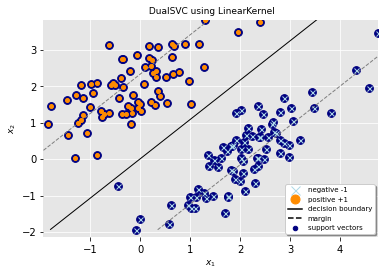

svc accuracy score is 1.0
svc found 150 support vectors from 150 examples
svc w is [-0.46403167  0.43003388]
svc b is -0.0037076445161284594


In [100]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

In [101]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

#### Nonlinearly Separable Binary Classification

In order to extend the SVM methodology to handle data that is not fully linearly separable, we relax the constraints for (1.1) and (1.2) slightly to allow for misclassified points. This is done by introducing a positive slack variable $\xi_{i}, i=1$, $\dots$, $n$ :

$$
\begin{equation}
    \langle w, x_i \rangle +b\geq+1-\xi_{i} \ \text{for} \ y_{i}=+1 \tag{2.1}
\end{equation}
$$
$$
\begin{equation}
    \langle w, x_i \rangle +b\leq-1+\xi_{i} \ \text{for} \ y_{i}=-1 \tag{2.2}
\end{equation}
$$ 

$$\text{where} \ \xi_{i}\geq 0 \ \forall_{i}$$

Which can be combined into:

$$
\begin{equation}
    y_{i}(\langle w, x_i \rangle +b) \geq 1 - \xi_{i} \ \forall_{i} \text{where} \ \xi_{i}\geq 0 \ \forall_{i} \tag{2.3}
\end{equation}
$$

<img src="./img/svc_soft.png" width=600/>

In this *soft margin* SVM, data points on the incorrect side of the margin boundary have a penalty that increases with the distance from it. As we are trying to reduce the number of misclassifications, a sensible way to adapt our objective function (1.7) from previously, is to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi} \quad & \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^{n} \xi_{i} \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 - \xi_{i} \ \forall_{i} \\ & \xi_{i} \geq 0 \ \forall_{i}
    \end{aligned} \tag{2.4}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 + C 
        \begin{cases}
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b)) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b))^2 & \text{if using L2 loss}
          \end{cases} \tag{2.5}
\end{equation}
$$

where we make use of the Hinge (L1 loss) and squared Hinge (L2 loss) loss respectively.

In [6]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.4815 - val_acc:  0.6000
  50	  50	 1.3007e-01 - val_loss:  1.3815e-01 - acc:  0.9704 - val_acc:  1.0000
 100	 100	 1.0180e-01 - val_loss:  1.2326e-01 - acc:  0.9704 - val_acc:  1.0000
 150	 150	 8.8815e-02 - val_loss:  1.1952e-01 - acc:  0.9704 - val_acc:  1.0000
 200	 200	 8.2817e-02 - val_loss:  1.2094e-01 - acc:  0.9704 - val_acc:  1.0000
 250	 250	 7.8492e-02 - val_loss:  1.2176e-01 - acc:  0.9704 - val_acc:  1.0000
 300	 300	 7.5675e-02 - val_loss:  1.2817e-01 - acc:  0.9704 - val_acc:  1.0000
 350	 350	 7.4555e-02 - val_loss:  1.3077e-01 - acc:  0.9704 - val_acc:  1.0000
 400	 400	 7.3932e-02 - val_loss:  1.3481e-01 - acc:  0.9704 - val_acc:  1.0000
 450	 450	 7.3467e-02 - val_loss:  1.3640e-01 - acc:  0.9704 - val_acc:  1.0000
 500	 500	 7.3021e-02 - val_loss:  1.3838e-01 - acc:  0.9704 - val_acc:  1.0000
 550	 550	 7.2658e-02 - val_loss:  1.3956e-01 - acc:  0.9704 - val_acc:  1.0000
 600	 600	 7.2287e-02 

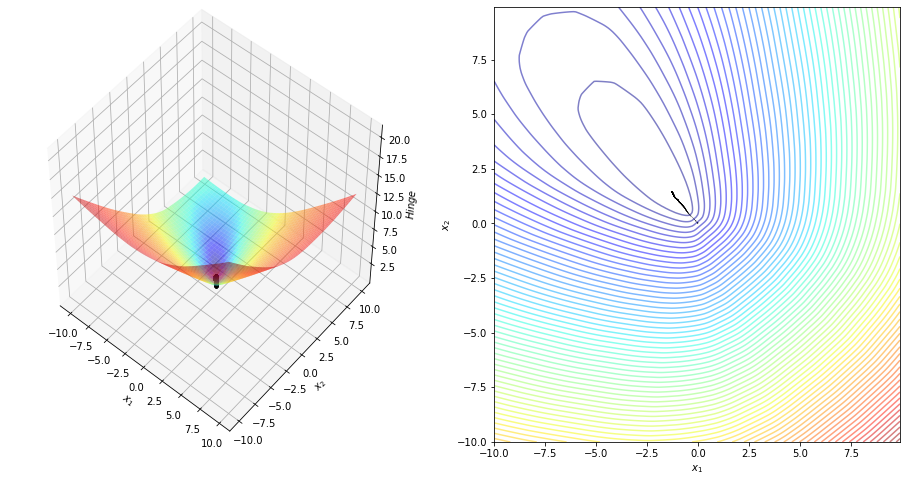

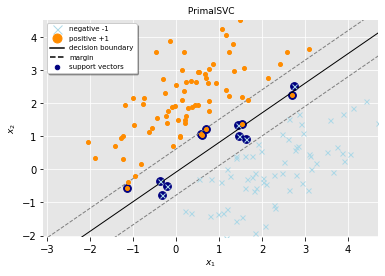

svc accuracy score is 0.96
svc found 13 support vectors from 150 examples
svc w is [-1.28280262  1.43174757]
svc b is 0.11867610967117834

1.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


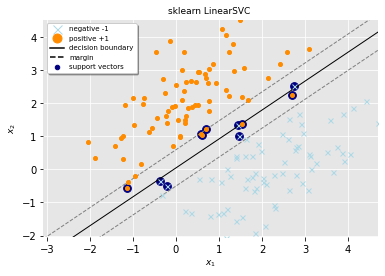

sklearn svc accuracy score is 0.94
sklearn svc found 11 support vectors from 150 examples
sklearn svc w is [[-1.59275647  1.82071852]]
sklearn svc b is [-0.08339641]


In [103]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [104]:
results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.5037 - val_acc:  0.3333
  50	  50	 3.1662e-02 - val_loss:  1.1320e-01 - acc:  1.0000 - val_acc:  1.0000
 100	 100	 2.8344e-02 - val_loss:  1.3318e-01 - acc:  1.0000 - val_acc:  1.0000
 150	 150	 2.7800e-02 - val_loss:  1.4911e-01 - acc:  1.0000 - val_acc:  1.0000
 200	 200	 2.8487e-02 - val_loss:  1.6428e-01 - acc:  1.0000 - val_acc:  1.0000
 250	 250	 2.9286e-02 - val_loss:  1.7623e-01 - acc:  1.0000 - val_acc:  1.0000
 300	 300	 2.9878e-02 - val_loss:  1.8488e-01 - acc:  1.0000 - val_acc:  1.0000
 350	 350	 3.0165e-02 - val_loss:  1.9073e-01 - acc:  1.0000 - val_acc:  1.0000
 400	 400	 3.0572e-02 - val_loss:  1.9602e-01 - acc:  1.0000 - val_acc:  1.0000
 450	 450	 3.0882e-02 - val_loss:  2.0165e-01 - acc:  1.0000 - val_acc:  1.0000
 500	 500	 3.1298e-02 - val_loss:  2.0672e-01 - acc:  1.0000 - val_acc:  1.0000
 550	 550	 3.1623e-02 - val_loss:  2.1210e-01 - acc:  1.0000 - val_acc:  1.0000
 600	 600	 3.2044e-02 

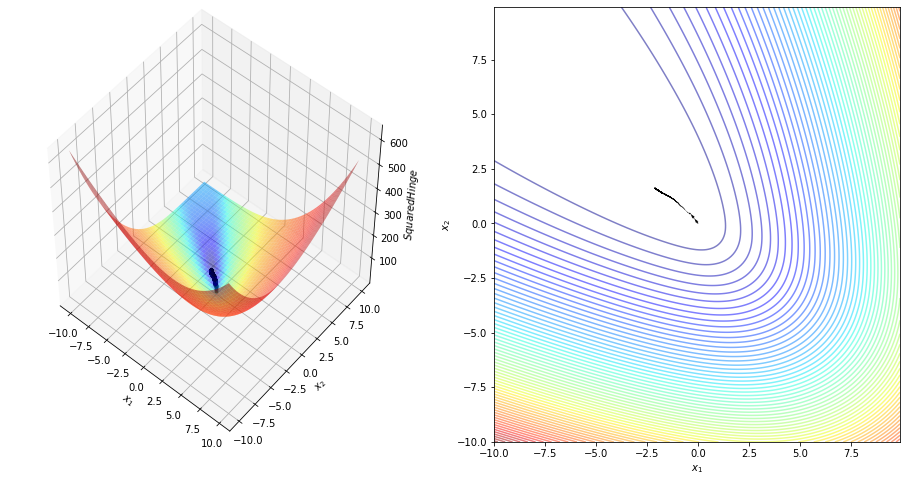

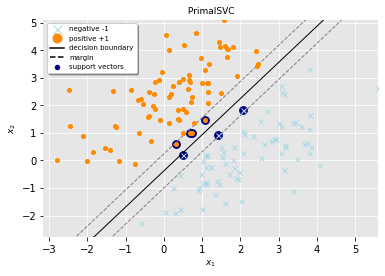

svc accuracy score is 1.0
svc found 7 support vectors from 150 examples
svc w is [-2.11795466  1.61174785]
svc b is 0.6073439018244461

1.13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


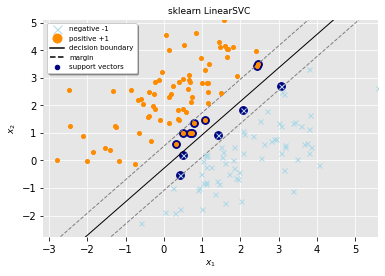

sklearn svc accuracy score is 1.0
sklearn svc found 13 support vectors from 150 examples
sklearn svc w is [[-1.51425519  1.24473753]]
sklearn svc b is [0.35468515]


In [105]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='squared_hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [106]:
results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

Where the parameter $C$ controls the trade-off between the slack variable penalty and the size of the margin. Reformulating as a Lagrangian, which as before we need to minimize with respect to $w$, $b$ and $\xi_{i}$ and maximize with respect to $\alpha$ (where $\alpha_{i} \geq 0, \mu_{i} \geq 0 \ \forall_{i}$):

$$
\begin{equation}
    \mathcal{W}(w,b,\xi,\alpha) \displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C\sum_{i=1}^n\xi_{i}-\sum_{i=1}^n\alpha_{i}[y_{i}(\langle w, {x}_{i} \rangle+b)-1+\xi_{i}]-\sum_{i=1}^n\mu_{i}\xi_{i} \tag{2.6}
\end{equation}
$$

Differentiating with respect to $w$, $b$ and $\xi_{i}$ and setting the derivatives to zero:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}\alpha_{i}y_{i}x_i \tag{2.7}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=0\Rightarrow\sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{2.8}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_{i}}=0\Rightarrow C=\alpha_{i}+\mu_{i} \tag{2.9}
\end{equation}
$$

Substituting these in, $\mathcal{W}(\alpha)$ has the same form as (1.16) before. However (2.9) together with $\mu_{i}\geq 0 \ \forall_{i}$, implies that $\alpha\leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2}\alpha^{T}Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & 0\leq\alpha_{i}\leq C \ \forall_{i} \\ & y^T\alpha=0 
    \end{aligned} \tag{2.10}
\end{equation}
$$

where $q$ is a vector of all ones.

$b$ is then calculated in the same way as in (1.7) before, though in this instance the set of support vectors used to calculate $b$ is determined by finding the indices $i$ where $0\leq\alpha_{i}\leq C$.

In [4]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-9.8025e-01
   1	-1.1147e+00
   2	-1.1248e+00
   3	-1.1249e+00
   4	-1.5101e+00
   5	-1.5385e+00
   6	-1.5450e+00
   7	-1.5450e+00
   8	-1.5694e+00
   9	-1.5733e+00
  10	-1.5737e+00
  11	-1.5737e+00

72.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


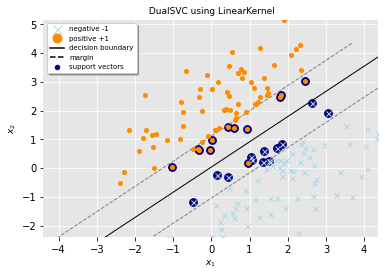

svc accuracy score is 0.96
svc found 24 support vectors from 150 examples
svc w is [-0.81270198  0.92740134]
svc b is -0.03553661409736783

     pcost       dcost       gap    pres   dres
 0: -1.5390e+01 -2.5807e+01  8e+02  2e+01  5e-15
 1: -2.8691e+00 -2.3536e+01  6e+01  1e+00  4e-15
 2: -1.3146e+00 -8.8406e+00  1e+01  9e-02  9e-16
 3: -1.2355e+00 -2.4100e+00  1e+00  1e-02  2e-15
 4: -1.4553e+00 -1.8112e+00  4e-01  3e-03  1e-15
 5: -1.5099e+00 -1.6998e+00  2e-01  1e-03  7e-16
 6: -1.5509e+00 -1.6104e+00  6e-02  3e-04  6e-16
 7: -1.5669e+00 -1.5832e+00  2e-02  6e-05  5e-16
 8: -1.5727e+00 -1.5751e+00  2e-03  2e-06  6e-16
 9: -1.5738e+00 -1.5739e+00  1e-04  1e-07  7e-16
10: -1.5738e+00 -1.5738e+00  1e-06  1e-09  7e-16
Optimal solution found.

52.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


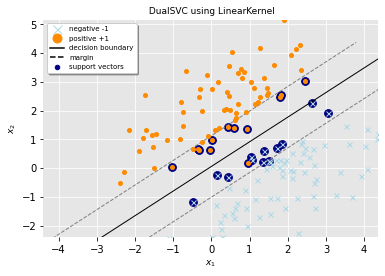

cvxopt svc accuracy score is 0.96
cvxopt svc found 24 support vectors from 150 examples
cvxopt svc w is [-0.80246289  0.937151  ]
cvxopt svc b is -0.054678354618216685

964 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


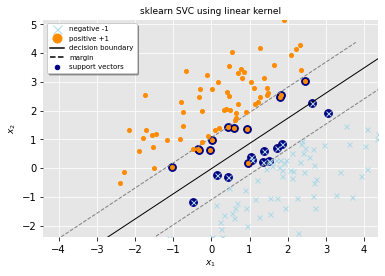

sklearn svc accuracy score is 0.96
sklearn svc found 24 support vectors from 150 examples
sklearn svc w is [[-0.81280037  0.92783584]]
sklearn svc b is [0.01787897]


In [108]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=0.1, optimizer=SMOClassifier, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=linear, C=0.1, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
cvxopt_support_vectors = len(svc.support_)
print(f'cvxopt svc found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svc w is {svc.coef_}')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='linear', C=0.1)
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
sklearn_support_vectors = len(svc.support_)
print(f'sklearn svc found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [109]:
results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

In order to relax the box-constraints in the *Wolfe dual* formulation (2.10) to define the problem as a *Lagrangian dual* relaxation by embedding them into objective function we need to allocate the Lagrangian multipliers $\lambda$:

$$
\begin{align*}
    \mathcal{L}(\alpha, \lambda_+, \lambda_-) &= \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha - \lambda_+^T (ub - \alpha) - \lambda_-^T \alpha \\
    &= \displaystyle \frac{1}{2} \alpha^{T}Q\alpha + (q + \lambda_+ - \lambda_-)^T \alpha - \lambda_+^T ub \tag{1.20}
\end{align*}
$$

where $\lambda_+$ and $\lambda_-$ are the first and last $m$ components of $\lambda$ respectively, both constrained to be $\geq 0$.

In [4]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.6151e-01	ub: -1.6151e-01 - pcost:  1.6151e-01 - gap:  3.2301e-01
   1	   1	 1.3075e+00	ub:  1.6151e-01 - pcost:  1.6151e-01 - gap:  0.0000e+00

19.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


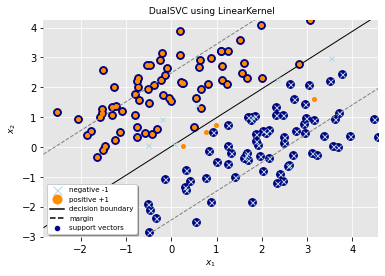

svc accuracy score is 0.96
svc found 140 support vectors from 150 examples
svc w is [-0.39147723  0.40711149]
svc b is -0.01051777685269135


In [110]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=0.1, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

In [111]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

### Support Vector Regression

Instead of attempting to classify new unseen variables $x'$ into one of two categories $y'=\pm 1$, we now wish to predict a real-valued output for $y'$ so that our training data is of the form:

$$
\{x_i,y_i\} \text{where i}=1, \dots, n, x\in\Re^{m}, y_{i}\in\Re
$$

The regression SVM will use a more sophisticated penalty function than before, not allocating a penalty if the predicted value $y'_{i}$ is less than a distance $\epsilon$ away from the actual value $y_{i}$, i.e., if $|y_{i}-y'_{i}|<\epsilon$. 

<img src="./img/svr.png" width=600/>

Referring to this figure, the region bound by $y'_{i}\pm\epsilon \ \forall_{i}$ is called an $\epsilon$-insensitive tube. The other modification to the penalty function is that output variables which are outside the tube are given one of two slack variable penalties depending on whether they lie above $(\xi^{+})$ or below $(\xi^{-})$ the tube (where $\xi^{+} \geq 0, \xi^{-} \geq 0 \ \forall_{i}$):

$$
\begin{equation}
    y_{i}\leq y'_{i}+\epsilon+\xi^{+} \tag{3.1}
\end{equation}
$$
$$
\begin{equation}
    y_{i}\geq y'_{i}-\epsilon-\xi^{-} \tag{3.2}
\end{equation}
$$

The error function for SVM regression can then be written as:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi^{+},\xi^{-}} \quad & \frac{1}{2}\Vert w\Vert^{2} + C \sum_{i=1}^{n}(\xi_{i}^{+}+\xi_{i}^{-}) \\
            \textrm{subject to} \quad & y_{i} - \langle w, x_i \rangle - b \leq \epsilon + \xi_{i}^{+} \ \forall_{i} \\ & \langle w, x_i \rangle + b - y_{i} \leq \epsilon + \xi_{i}^{-} \ \forall_{i} \\ & \xi_{i}^{+}, \xi_{i}^{-} \geq 0 \ \forall_{i}
    \end{aligned} \tag{3.3}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_ {w, b} \frac{1}{2} \Vert w\Vert^{2} + C 
        \begin{cases}
            \sum_{i=1}^n \max(0, |y_i - (\langle w, x_i \rangle + b)| - \epsilon) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, |y_i - (\langle w, x_i \rangle + b)| - \epsilon)^2 & \text{if using L2 loss}
          \end{cases} \tag{3.4}
\end{equation}
$$

where we make use of the epsilon-insensitive (L1 loss) and squared epsilon-insensitive (L2 loss) loss respectively, i.e., errors of less than $\epsilon$ are ignored.

In [28]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SKLinearSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 4.9154e+01 - val_loss:  3.2580e+01 - r2: -0.0003
  50	  50	 3.8130e+01 - val_loss:  4.0267e+01 - r2:  0.4593
 100	 100	 3.4113e+01 - val_loss:  5.5808e+01 - r2:  0.6341
 150	 150	 3.1930e+01 - val_loss:  7.0799e+01 - r2:  0.7330
 200	 200	 3.0540e+01 - val_loss:  8.4832e+01 - r2:  0.7985
 250	 250	 2.9606e+01 - val_loss:  9.7822e+01 - r2:  0.8449
 300	 300	 2.8972e+01 - val_loss:  1.0978e+02 - r2:  0.8790
 350	 350	 2.8525e+01 - val_loss:  1.2074e+02 - r2:  0.9046
 400	 400	 2.8211e+01 - val_loss:  1.3076e+02 - r2:  0.9241
 450	 450	 2.8004e+01 - val_loss:  1.3990e+02 - r2:  0.9392
 500	 500	 2.7871e+01 - val_loss:  1.4821e+02 - r2:  0.9509
 550	 550	 2.7785e+01 - val_loss:  1.5576e+02 - r2:  0.9601
 600	 600	 2.7737e+01 - val_loss:  1.6262e+02 - r2:  0.9674
 650	 650	 2.7721e+01 - val_loss:  1.6895e+02 - r2:  0.9731
 700	 700	 2.7723e+01 - val_loss:  1.7468e+02 - r2:  0.9777
 750	 750	 2.7753e+01 - val_loss:  1.7985e+02 - r2:  0.9813
 800	 800	 2.7792e+01 

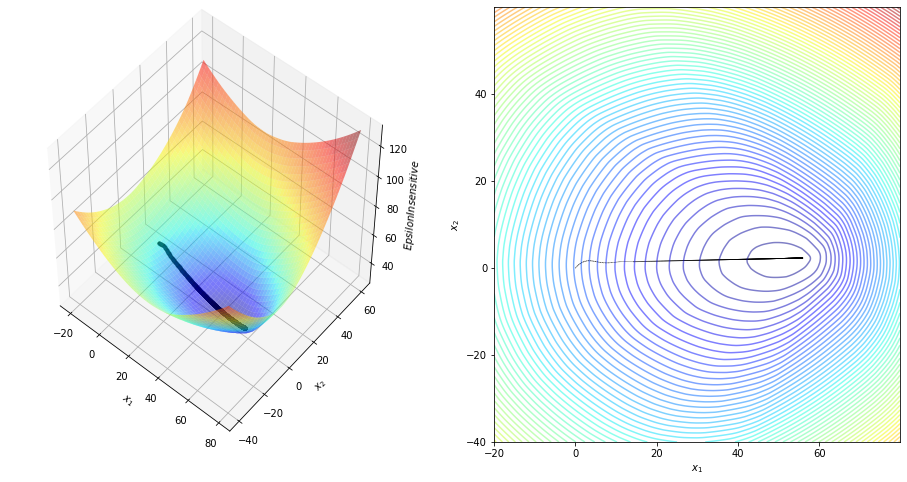

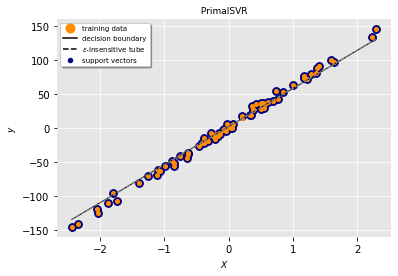

svr accuracy score is 0.9914063149130515
svr found 98 support vectors from 75 examples
svr w is [55.97076493]
svr b is 2.2629597528846617

395 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


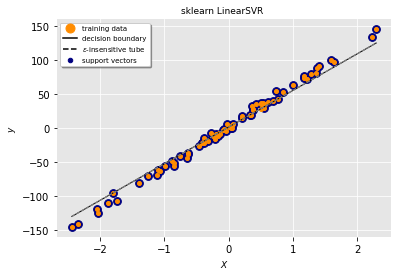

sklearn svr accuracy score is 0.9857265506794366
sklearn svr found 98 support vectors from 75 examples
sklearn svr w is [53.83213379]
sklearn svr b is [1.46853147]


In [112]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=epsilon_insensitive, epsilon=0.1, optimizer=AdaGrad, 
                learning_rate_init=0.15, momentum_type='nesterov', 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, -20, 80, -40, 60)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'svr found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='epsilon_insensitive', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [113]:
results['formulation'].append('primal')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(len(sklearn_support_vectors))

epoch	iter	 cost	
   0	   0	 4.2792e+03 - val_loss:  1.4198e+03 - r2: -0.0011
  50	  50	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 100	 100	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 150	 150	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 200	 200	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 250	 250	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 300	 300	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 350	 350	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 400	 400	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 450	 450	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 500	 500	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 550	 550	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 600	 600	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 650	 650	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 700	 700	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 750	 750	 3.9623e+01 - val_loss:  2.4604e+02 - r2:  0.9969
 800	 800	 3.9623e+01 

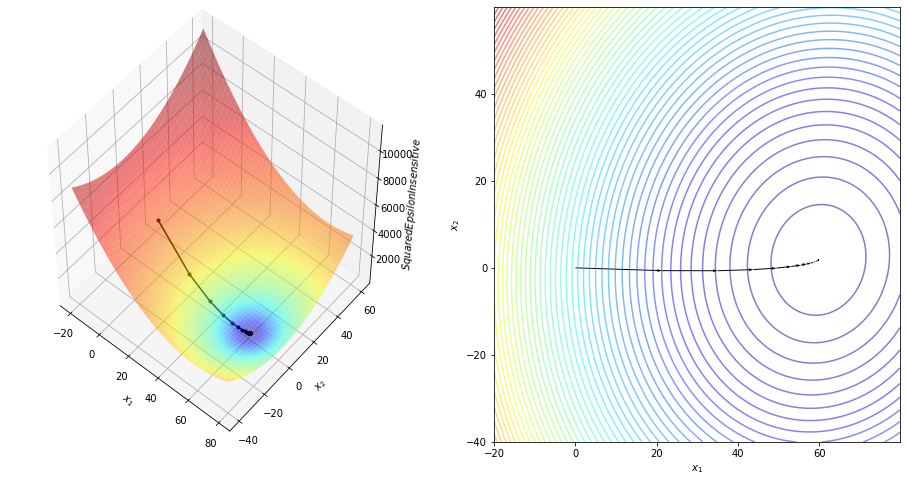

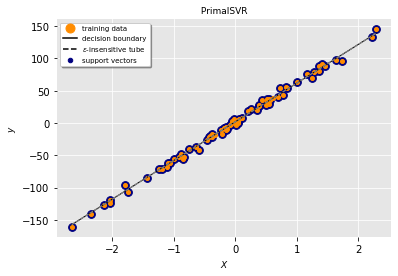

svr accuracy score is 0.9962331307029956
svr found 98 support vectors from 75 examples
svr w is [59.83358787]
svr b is 1.8324592212741477

949 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


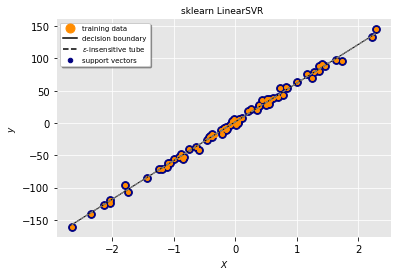

sklearn svr accuracy score is 0.9961884990115247
sklearn svr found 97 support vectors from 75 examples
sklearn svr w is [59.84751675]
sklearn svr b is [1.75489827]


In [115]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=squared_epsilon_insensitive, epsilon=0.1, 
                optimizer=StochasticGradientDescent, 
                learning_rate_init=0.15, early_stopping=False, 
                validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, -20, 80, -40, 60)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'svr found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='squared_epsilon_insensitive', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [116]:
results['formulation'].append('primal')
results['loss'].append('squared_epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('squared_epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(len(sklearn_support_vectors))

This needs to be minimized subject to the constraints $\xi^{+}\geq 0, \xi^{-}\geq 0 \ \forall_{i}$ and (3.1) and (3.2). In order to do this we introduce Lagrange multipliers $\alpha_{i}^{+}\geq 0, \alpha_{i}^{-}\geq 0, \mu_{i}^{+}\geq 0\mu_{i}^{-}\geq 0 \ \forall_{i}$:

$$
\begin{equation}
    \mathcal{W}(w,b,\xi^{+},\xi^{-}) \displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C \sum_{i=1}^n(\xi_{i}^{+}+\xi_{i}^{-})-\sum_{i=1}^n(\mu_{i}^{+}\xi_{i}^{+}+\mu_{i}^{-}\xi_{i}^{-})-\sum_{i=1}^n\alpha_{i}^{+}(\epsilon+\xi_{i}^{+}+y'_{i}-y_{i})-\sum_{i=1}^n\alpha_{i}^{-}(\epsilon+\xi_{i}^{-}-y'_{i}+y_{i}) \tag{3.5}
\end{equation}
$$

Substituting for $y_{i}$, differentiating with respect to $w, b, \xi^{+}$ and $\xi^{-}$ and setting the derivatives to $0$:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})x_{i} \tag{3.6}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=0\Rightarrow \sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})=0 \tag{3.7}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_{i}^{+}}=0\Rightarrow C=\alpha_{i}^{+}+\mu_{i}^{+} \tag{3.8}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_{i}^{-}}=0\Rightarrow C=\alpha_{i}^{-}+\mu_{i}^{-} \tag{3.9}
\end{equation}
$$

Substituting (3.6) and (3.7) in, we now need to maximize $L_{D}$ with respect to $\alpha_{i}^{+}$ and $\alpha_{i}^{-}(\alpha_{i}^{+}\geq 0,\ \alpha_{i}^{-}\geq 0 \ \forall_{i})$ where:

$$
\begin{equation}
    \mathcal{W}(\alpha^{+},\alpha^{-}) = \displaystyle \sum_{i=1}^{n}y_{i}(\alpha_{i}^{+}-\alpha_{i}^{-})-\epsilon\sum_{i=1}^{n}(\alpha_{i}^{+}+\alpha_{i}^{-})-\frac{1}{2}\sum_{i,j}(\alpha_{i}^{+}-\alpha_{i}^{-})\langle x_i, x_j \rangle(\alpha_{j}^{+}-\alpha_{j}^{-}) \tag{3.10}
\end{equation}
$$

Using $\mu_{i}^{+}\geq 0$ and $\mu_{i}^{-}\geq 0$ together with (3.8) and (3.9) means that $\alpha_{i}^{+}\leq C$ and $\alpha_{i}^{-}\leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha^+,\alpha^-} \quad & \frac{1}{2}(\alpha^{+}-\alpha^{-})^TQ(\alpha^{+}-\alpha^{-})+\epsilon q^T(\alpha^{+}+\alpha^{-})-y^T(\alpha^{+}-\alpha^{-}) \\
            \textrm{subject to} \quad & 0\leq\alpha_{i}^{+},\alpha_{i}^{-}\leq C \ \forall_{i} \\ & q^T(\alpha^{+}-\alpha^{-})=0
    \end{aligned} \tag{3.11}
\end{equation}
$$

where $q$ is a vector of all ones.

Each new predictions $y'$ can be found using:

$$
\begin{equation}
    y'=\displaystyle \sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})\langle x_{i}, x' \rangle+b \tag{3.12}
\end{equation}
$$

A set $S$ of Support Vectors $x_{s}$ can be created by finding the indices $i$ where $0\leq\alpha\leq C$ and $\xi_{i}^{+}=0$ (or $\xi_{i}^{-}=0$).

This gives us:

$$
\begin{equation}
    b=y_{s}-\displaystyle \epsilon-\sum_{m\in S}(\alpha_m^+ -\alpha_m^-) \langle x_{m}, x_{s} \rangle \tag{3.13}
\end{equation}
$$

As before it is better to average over all the indices $i$ in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_{s}}\sum_{s\in S}y_{s}-\epsilon-\sum_{m\in S}(\alpha_{m}^{+}-\alpha_{m}^{-})\langle x_{m}, x_{s} \rangle \tag{3.14}
\end{equation}
$$

In [7]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.8470e+03
   1	-1.8498e+03
   2	-1.8717e+03
   3	-1.8719e+03
   4	-1.8781e+03
   5	-1.8786e+03
   6	-1.8789e+03
   7	-1.8814e+03
   8	-1.8814e+03
   9	-1.8817e+03
  10	-1.8817e+03
  11	-1.8817e+03

25 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


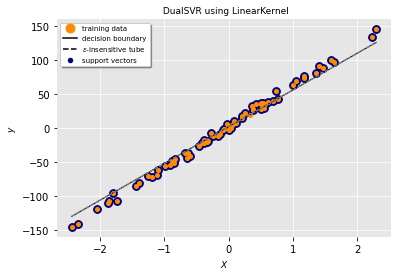

svr accuracy score is 0.9854965380312973
svr found 72 support vectors from 75 examples
svr w is [53.98438747]
svr b is 2.0286602057817897

     pcost       dcost       gap    pres   dres
 0: -2.7763e+03 -2.6151e+03  9e+03  7e+00  3e-16
 1: -2.0322e+03 -2.4504e+03  1e+03  9e-01  2e-16
 2: -1.9277e+03 -2.1712e+03  5e+02  3e-01  2e-16
 3: -1.8898e+03 -2.0438e+03  3e+02  1e-01  1e-16
 4: -1.8728e+03 -1.9092e+03  5e+01  2e-02  2e-16
 5: -1.8791e+03 -1.8908e+03  1e+01  5e-03  1e-16
 6: -1.8811e+03 -1.8864e+03  6e+00  2e-03  1e-16
 7: -1.8819e+03 -1.8847e+03  3e+00  8e-04  1e-16
 8: -1.8823e+03 -1.8838e+03  1e+00  4e-05  2e-16
 9: -1.8829e+03 -1.8831e+03  2e-01  5e-06  2e-16
10: -1.8830e+03 -1.8830e+03  2e-03  5e-08  2e-16
11: -1.8830e+03 -1.8830e+03  2e-05  5e-10  1e-16
Optimal solution found.

86.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


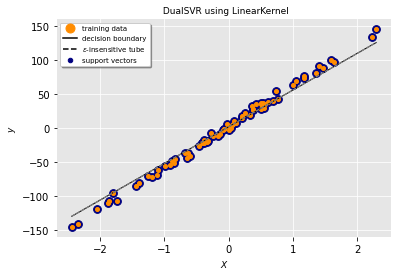

cvxopt svr accuracy score is 0.9853073970731827
cvxopt svr found 74 support vectors from 75 examples
cvxopt svr w is [53.92029478]
cvxopt svr b is 1.990698173082656

942 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


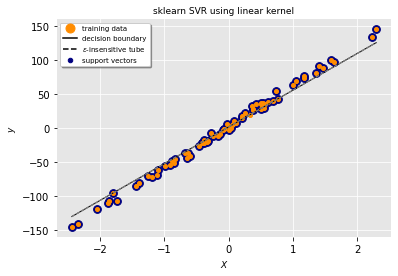

sklearn svr accuracy score is 0.985794823857303
sklearn svr found 72 support vectors from 75 examples
sklearn svr w is [[53.98438778]]
sklearn svr b is [1.68993798]


In [119]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer=SMORegression, verbose=True)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
cvxopt_r2 = svr.score(X_test, y_test)
print(f'cvxopt svr r2 score is {cvxopt_r2}')
cvxopt_support_vectors = len(svr.support_)
print(f'cvxopt svr found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svr w is {svr.coef_}')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='linear', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = len(svr.support_)
print(f'sklearn svr found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [120]:
results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_r2)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(sklearn_support_vectors)

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [7]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.8086e+03	ub: -1.8086e+03 - pcost:  1.8086e+03 - gap:  2.0000e+00
   1	   1	-1.7888e+03	ub:  1.8086e+03 - pcost:  1.8086e+03 - gap:  0.0000e+00

29.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


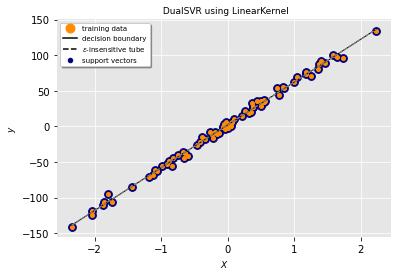

svr r2 score is 0.9984224396749961
svr found 72 support vectors from 75 examples
svr w is [60.10366606]
svr b is 2.17737486933256


In [121]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

In [122]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

### Nonlinear Support Vector Machines

When applying our SVM to linearly separable data we have started by creating a matrix $Q$ from the dot product of our input variables:

$$ Q_{ij}=y_{i}y_{j}k(x_{i},\ x_{j})= \langle x_{i}, x_{j} \rangle=x_{i}^{T}x_{j} $$

$k(x_{i},x_{j})$ is an example of a family of functions called *kernel functions* where $k(x_{i},x_{j})=\langle x_{i}, x_{j} \rangle$ being known as a *linear* kernel. The set of kernel functions is composed of variants of (3.1) in that they are all based on calculating inner products of two vectors. This means that if the functions can be recast into a higher dimensionality space by some potentially nonlinear feature mapping function $x\rightarrow \phi(x)$, only inner products of the mapped inputs in the feature space need be determined without us needing to explicitly calculate $\phi$.

The reason that this *kernel trick* is useful is that there are many classification/regression problems that are not linearly separable/regressable in the space of the inputs $x$, which might be in a higher dimensionality feature space given a suitable mapping $x \rightarrow \phi(x)$.

#### Polynomial Kernel

The *polynomial* kernel is defined as:

$$k(x_{i},x_{j})=(\gamma \langle x_i, x_j\rangle + r)^d$$

where $\gamma$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*, $d$ by *degree* and $r$ by *coef0*.

##### Support Vector Classifier

In [30]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-4.2632e-02
   3	-6.4706e-02
   6	-6.8920e-02
   9	-6.9356e-02
  12	-6.9485e-02
  15	-6.9509e-02
  18	-6.9514e-02
  21	-6.9515e-02
  24	-6.9598e-02
  27	-6.9648e-02
  30	-6.9650e-02
  33	-6.9651e-02
  36	-6.9652e-02
  39	-6.9652e-02

CPU times: user 719 ms, sys: 728 ms, total: 1.45 s
Wall time: 293 ms


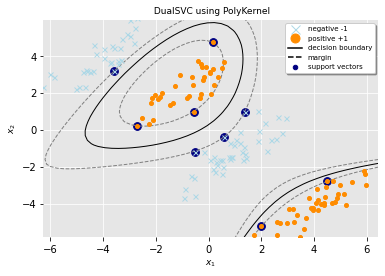

svc accuracy score is 1.0
svc found 9 support vectors from 150 examples
svc b is -0.23969380392788336

     pcost       dcost       gap    pres   dres
 0: -2.8704e+01 -3.8215e+02  2e+03  3e+00  7e-12
 1: -1.5258e+01 -2.3770e+02  5e+02  5e-01  5e-12
 2: -5.3015e+00 -7.1534e+01  1e+02  1e-01  3e-12
 3: -1.0227e+00 -1.4587e+01  2e+01  2e-02  1e-12
 4: -1.9940e-02 -1.9460e+00  3e+00  2e-03  2e-13
 5:  2.5241e-03 -3.2309e-01  4e-01  2e-04  4e-14
 6: -3.0645e-02 -1.4819e-01  1e-01  8e-05  1e-14
 7: -5.4889e-02 -9.7751e-02  5e-02  2e-05  3e-15
 8: -6.6004e-02 -7.9431e-02  1e-02  4e-07  2e-15
 9: -6.9025e-02 -7.3073e-02  4e-03  1e-07  2e-15
10: -6.9875e-02 -7.1355e-02  1e-03  6e-09  2e-15
11: -7.0424e-02 -7.0627e-02  2e-04  8e-10  2e-15
12: -7.0507e-02 -7.0519e-02  1e-05  1e-11  2e-15
13: -7.0512e-02 -7.0513e-02  1e-07  1e-13  3e-15
14: -7.0512e-02 -7.0512e-02  1e-09  1e-15  2e-15
Optimal solution found.

CPU times: user 261 ms, sys: 267 ms, total: 528 ms
Wall time: 93.5 ms


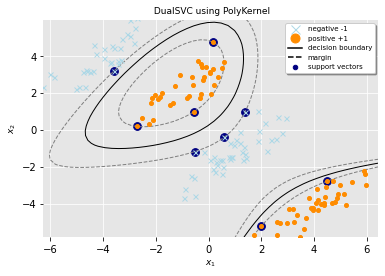

cvxopt svc accuracy score is 1.0
cvxopt svc found 9 support vectors from 150 examples
cvxopt svc b is 1.4529548830743977e-07

CPU times: user 1.49 ms, sys: 0 ns, total: 1.49 ms
Wall time: 1.37 ms


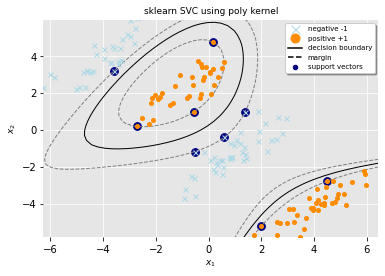

sklearn svc accuracy score is 1.0
sklearn svc found 9 support vectors from 150 examples
sklearn svc b is [-0.21552255]


In [31]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer=SMOClassifier, verbose=3)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer='cvxopt', verbose=3)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='poly', degree=3, coef0=3, gamma='auto')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [9]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.0434e-02	ub: -1.0434e-02 - pcost:  1.0434e-02 - gap:  2.0868e-02
   1	   1	 1.4987e+01	ub:  1.0434e-02 - pcost:  1.0434e-02 - gap:  0.0000e+00

CPU times: user 89.9 ms, sys: 55 ms, total: 145 ms
Wall time: 23.8 ms


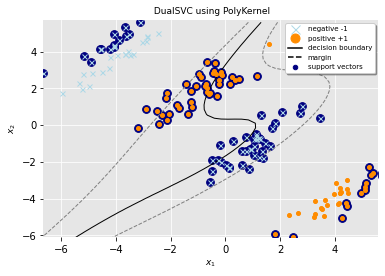

svc accuracy score is 0.7
svc found 108 support vectors from 150 examples
svc b is 0.049027815831740186


In [11]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer=AdaGrad, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

#### Gaussian RBF Kernel

The *gaussian* kernel is defined as:

$$k(x_{i},x_{j})=\exp(-\frac{\|x_i-x_j\|_2^2}{2\sigma^2})$$

or, equivalently, as:

$$k(x_{i},x_{j})=\exp(-\gamma \|x_i-x_j\|_2^2)$$

where $\displaystyle \gamma=\frac{1}{2\sigma^2}$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*.

##### Support Vector Classifier

In [22]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-7.4206e+00
   1	-8.3461e+00
   2	-8.4640e+00
   3	-8.5023e+00
   4	-8.5119e+00
   5	-8.5179e+00
   6	-8.5188e+00
   7	-8.5189e+00
   8	-8.5190e+00
   9	-9.0075e+00
  10	-9.0450e+00
  11	-9.0541e+00
  12	-9.0557e+00
  13	-9.0564e+00
  14	-9.0565e+00
  15	-9.0565e+00
  16	-9.0565e+00
  17	-9.0566e+00
  18	-9.0566e+00

CPU times: user 2.11 s, sys: 1.76 s, total: 3.86 s
Wall time: 647 ms


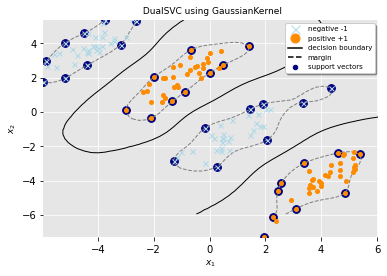

svc accuracy score is 1.0
svc found 36 support vectors from 150 examples
svc b is -0.011428984914708736

     pcost       dcost       gap    pres   dres
 0: -5.5617e+00 -1.8864e+02  2e+02  3e-17  4e-16
 1: -7.6772e+00 -1.6930e+01  9e+00  2e-16  4e-16
 2: -8.4992e+00 -1.0643e+01  2e+00  1e-16  2e-16
 3: -8.9386e+00 -9.3214e+00  4e-01  2e-16  2e-16
 4: -9.0299e+00 -9.1161e+00  9e-02  2e-16  2e-16
 5: -9.0554e+00 -9.0620e+00  7e-03  2e-16  2e-16
 6: -9.0576e+00 -9.0579e+00  4e-04  2e-16  2e-16
 7: -9.0577e+00 -9.0577e+00  7e-06  2e-16  2e-16
Optimal solution found.

CPU times: user 303 ms, sys: 321 ms, total: 624 ms
Wall time: 106 ms


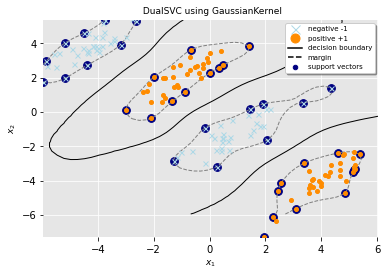

cvxopt svc accuracy score is 1.0
cvxopt svc found 40 support vectors from 150 examples
cvxopt svc b is -0.0007480255898352995

CPU times: user 1.36 ms, sys: 196 µs, total: 1.56 ms
Wall time: 1.15 ms


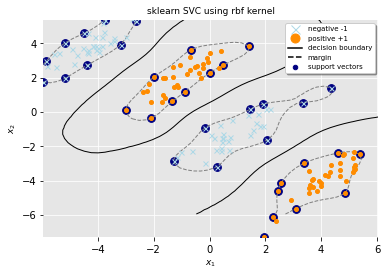

sklearn svc accuracy score is 1.0
sklearn svc found 36 support vectors from 150 examples
sklearn svc b is [-0.01115603]


In [23]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer=SMOClassifier, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer='cvxopt', verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='rbf', gamma='auto')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [13]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.0998e+01	ub: -1.0998e+01 - pcost:  1.0998e+01 - gap:  2.0000e+00
   1	   1	 2.2658e+01	ub:  1.0998e+01 - pcost:  1.0998e+01 - gap:  0.0000e+00

CPU times: user 309 ms, sys: 217 ms, total: 526 ms
Wall time: 80.9 ms


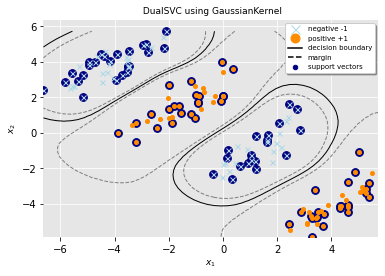

svc accuracy score is 1.0
svc found 93 support vectors from 150 examples
svc b is 0.946740705436948


In [14]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer=AdaGrad, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

##### Support Vector Regression

In [32]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.model_selection import train_test_split

iter	 cost
   0	-5.7036e-01
   2	-7.8643e-01
   4	-8.0455e-01
   6	-8.0519e-01
   8	-8.0630e-01
  10	-8.0683e-01
  12	-8.0684e-01
  14	-8.4285e-01
  16	-8.7306e-01
  18	-8.7915e-01
  20	-8.7941e-01
  22	-8.8016e-01
  24	-8.8035e-01
  26	-8.8041e-01
  28	-8.8041e-01

CPU times: user 494 ms, sys: 445 ms, total: 939 ms
Wall time: 162 ms


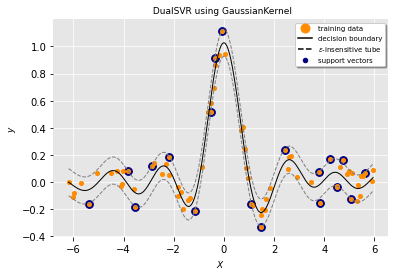

svr r2 score is 0.9747412565140712
svr found 19 support vectors from 75 examples
svr b is 0.09057627127557337

     pcost       dcost       gap    pres   dres
 0:  5.6430e+00 -1.7256e+02  2e+02  4e-17  1e-14
 1:  4.7608e+00 -7.6893e+00  1e+01  1e-16  2e-14
 2:  5.1340e-01 -2.6814e+00  3e+00  2e-16  1e-14
 3: -4.3035e-01 -1.4687e+00  1e+00  2e-16  7e-15
 4: -7.4673e-01 -1.0544e+00  3e-01  1e-16  4e-15
 5: -8.4191e-01 -9.3811e-01  1e-01  2e-16  3e-15
 6: -8.7346e-01 -8.9630e-01  2e-02  2e-16  4e-15
 7: -8.8262e-01 -8.8507e-01  2e-03  2e-16  3e-15
 8: -8.8370e-01 -8.8375e-01  4e-05  2e-16  4e-15
 9: -8.8372e-01 -8.8372e-01  4e-07  2e-16  4e-15
Optimal solution found.

CPU times: user 71.6 ms, sys: 73.8 ms, total: 145 ms
Wall time: 26.7 ms


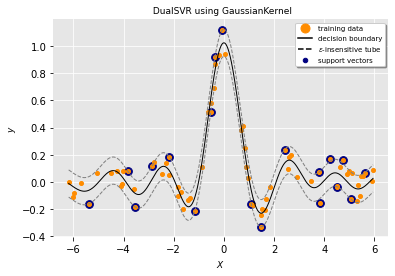

cvxopt svr r2 score is 0.9764859261430812
cvxopt svr found 19 support vectors from 75 examples
cvxopt svr b is 0.07582553499802264

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 835 µs


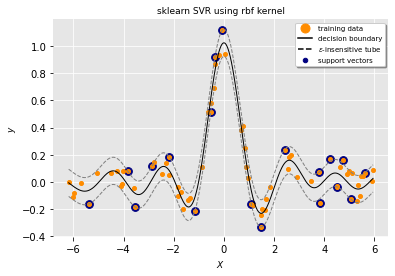

sklearn svr r2 score is 0.9764313598554
sklearn svr found 19 support vectors from 75 examples
sklearn svr b is [0.08521126]


In [33]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), optimizer=SMORegression, verbose=2)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), optimizer='cvxopt', verbose=2)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='rbf', gamma='auto')
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [34]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-6.1335e+02	ub: -6.1335e+02 - pcost:  6.1335e+02 - gap:  2.0000e+00
   1	   1	 4.3354e+03	ub:  6.1335e+02 - pcost:  6.1335e+02 - gap:  0.0000e+00

CPU times: user 584 ms, sys: 573 ms, total: 1.16 s
Wall time: 229 ms


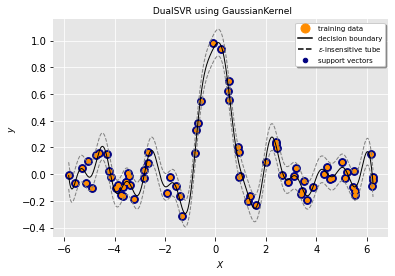

svr r2 score is -1.1700016605359722
svr found 75 support vectors from 75 examples
svr b is 0.31292945652116716


In [35]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), optimizer=AdaGrad, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

## Conclusions

In [102]:
import pandas as pd

df = pd.DataFrame(results)
df.style.hide_index()

formulation,loss,kernel,implementation,time,score,support_vectors
primal,hinge,linear,custom,0.596248,1.000000,5
primal,hinge,linear,sklearn,0.001335,1.000000,4
primal,squared_hinge,linear,custom,0.526772,1.000000,3
primal,squared_hinge,linear,sklearn,0.001087,1.000000,8
wolfe-dual,hinge,linear,custom,0.027193,1.000000,6
wolfe-dual,hinge,linear,cvxopt,0.110647,1.000000,5
wolfe-dual,hinge,linear,sklearn,0.001398,1.000000,6
lagrangian-dual,hinge,linear,custom,0.017210,1.000000,150


## References

[[1]](#ref-1) [J. Duchi, E. Hazan, Y. Singer. _Adaptive Subgradient Methods for Online Learning and Stochastic Optimization._](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

[[2]](#ref-2) [J.C. Platt. _Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines._](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

[[3]](#ref-3) [S.S. Keerthi, S.K. Shevade, C. Bhattacharyya, K.R.K. Murthy. _Improvements to Platt's SMO Algorithm for SVM Classifier Design._](http://web.cs.iastate.edu/~honavar/keerthi-svm.pdf)

[[4]](#ref-4) [G.W. Flake, S. Lawrence. _Efficient SVM Regression Training with SMO._](https://link.springer.com/content/pdf/10.1023/A:1012474916001.pdf)

[[5]](#ref-5) [S.K. Shevade, S.S. Keerthi, C. Bhattacharyya, K.R.K. Murthy. _Improvements to SMO Algorithm for SVM Regression._](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.8961&rep=rep1&type=pdf)